### source data : [yahoo-finance](https://finance.yahoo.com/quote/MSFT/history/)


## Lib Imports

In [1]:
import pandas as pd 
import re 
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

## Load Source Data:

In [2]:
url = f"https://raw.githubusercontent.com/rahulVemparala/source_data/main/ms_stock_2022_2023.csv"
df = pd.read_csv(url)

In [3]:
df = df[['Date', 'Close']]

df

,Date,Close
0,2022-04-25,280.720001
1,2022-04-26,270.220001
2,2022-04-27,283.220001
3,2022-04-28,289.630005
4,2022-04-29,277.519989
...,...,...
245,2023-04-17,288.799988
246,2023-04-18,288.369995
247,2023-04-19,288.450012
248,2023-04-20,286.109985


In [4]:
df['Date']

0      2022-04-25
1      2022-04-26
2      2022-04-27
3      2022-04-28
4      2022-04-29
          ...    
245    2023-04-17
246    2023-04-18
247    2023-04-19
248    2023-04-20
249    2023-04-21
Name: Date, Length: 250, dtype: object

In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [6]:
df

,Date,Close
0,2022-04-25,280.720001
1,2022-04-26,270.220001
2,2022-04-27,283.220001
3,2022-04-28,289.630005
4,2022-04-29,277.519989
...,...,...
245,2023-04-17,288.799988
246,2023-04-18,288.369995
247,2023-04-19,288.450012
248,2023-04-20,286.109985


In [7]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0     2022-04-25
1     2022-04-26
2     2022-04-27
3     2022-04-28
4     2022-04-29
         ...    
245   2023-04-17
246   2023-04-18
247   2023-04-19
248   2023-04-20
249   2023-04-21
Name: Date, Length: 250, dtype: datetime64[ns]

In [8]:
df.index = df.pop('Date')
df

,Close
Date,
2022-04-25,280.720001
2022-04-26,270.220001
2022-04-27,283.220001
2022-04-28,289.630005
2022-04-29,277.519989
...,...
2023-04-17,288.799988
2023-04-18,288.369995
2023-04-19,288.450012


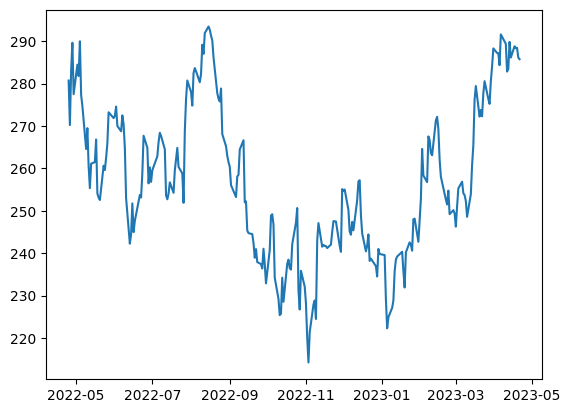

In [9]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [20]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=2):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2022-04-28', 
                                '2023-04-21', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-04-28,280.720001,270.220001,283.220001,289.630005
1,2022-04-29,270.220001,283.220001,289.630005,277.519989
2,2022-05-02,283.220001,289.630005,277.519989,284.470001
3,2022-05-03,289.630005,277.519989,284.470001,281.779999
4,2022-05-04,277.519989,284.470001,281.779999,289.980011
...,...,...,...,...,...
242,2023-04-17,283.489990,289.839996,286.140015,288.799988
243,2023-04-18,289.839996,286.140015,288.799988,288.369995
244,2023-04-19,286.140015,288.799988,288.369995,288.450012
245,2023-04-20,288.799988,288.369995,288.450012,286.109985


In [21]:
windowed_df.shape

(247, 5)

In [22]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((247,), (247, 3, 1), (247,))

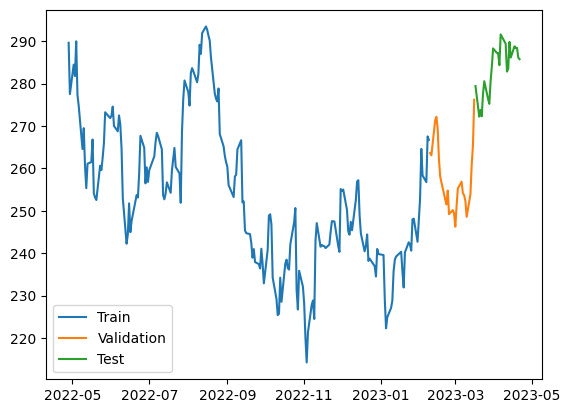

In [23]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 4s 109ms/step - loss: 64622.7578 - mean_absolute_error: 253.6218 - val_loss: 66385.5234 - val_mean_absolute_error: 257.5273
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 64452.9023 - mean_absolute_error: 253.2874 - val_loss: 66247.3516 - val_mean_absolute_error: 257.2588
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 64309.4883 - mean_absolute_error: 253.0034 - val_loss: 66093.8203 - val_mean_absolute_error: 256.9603
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 64156.5312 - mean_absolute_error: 252.7010 - val_loss: 65912.4922 - val_mean_absolute_error: 256.6072
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 63957.5742 - mean_absolute_error: 252.3079 - val_loss: 65669.0625 - val_mean_absolute_error: 256.1324
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 63682.7227 - mean_absolute_error: 251.7623 - val_loss: 65

7/7 [==============================] - 0s 3ms/step


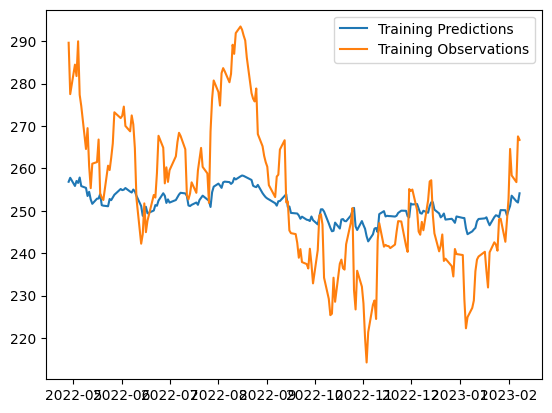

In [25]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 28ms/step


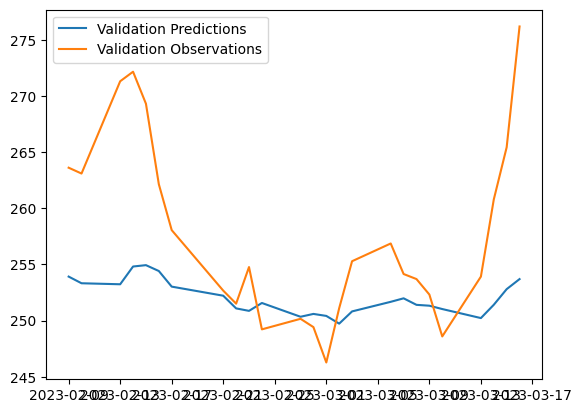

In [26]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 28ms/step


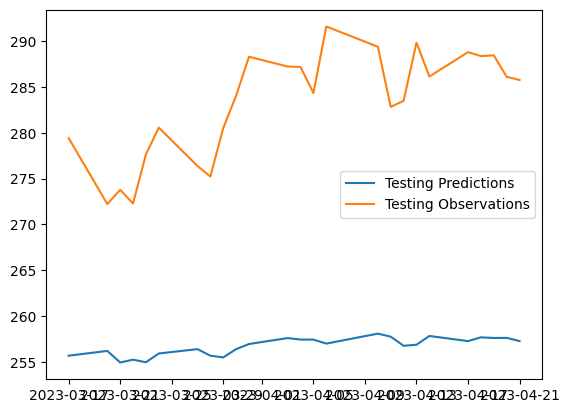

In [27]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

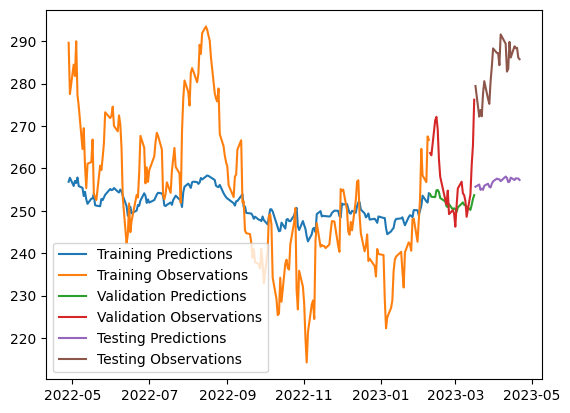

In [28]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [29]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 28ms/step


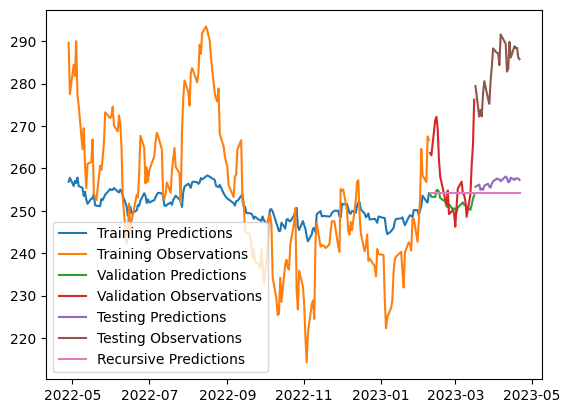

In [30]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

## Observations:

### Info data:
The data is stock exchangei nformation for the company Microsoft. I've collected data from last year to  the latest data (04-21-2023). 

## Trends and patterns:

1. As we can see from the first line graph (Open market price at eahc date), the date is pretty obsure, there is no definitve pattern or trends, as we can see sudden peeks and lows in the data. 

2. The latest data has a substantial influence on the source data, therefore a smaller subset of data would be better in modeling our LSTM cell.

## Trying a smaller subset. 



In [32]:
windowed_df = df_to_windowed_df(df, 
                                '2023-03-1', 
                                '2023-04-21', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2023-03-01,249.220001,250.160004,249.419998,246.270004
1,2023-03-02,250.160004,249.419998,246.270004,251.110001
2,2023-03-03,249.419998,246.270004,251.110001,255.289993
3,2023-03-06,246.270004,251.110001,255.289993,256.869995
4,2023-03-07,251.110001,255.289993,256.869995,254.149994
5,2023-03-08,255.289993,256.869995,254.149994,253.699997
6,2023-03-09,256.869995,254.149994,253.699997,252.320007
7,2023-03-10,254.149994,253.699997,252.320007,248.589996
8,2023-03-13,253.699997,252.320007,248.589996,253.919998
9,2023-03-14,252.320007,248.589996,253.919998,260.790009


In [33]:
windowed_df.shape

(37, 5)

In [34]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)


In [36]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]


In [42]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[3, 1]),
    keras.layers.Dense(1, activation=None)
])


model.compile(loss="mse", optimizer='Adam')

history = model.fit(X_train, y_train, epochs=30)

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 53099.5000
Epoch 2/30
1/1 [==============================] - 0s 14ms/step - loss: 51711.2578
Epoch 3/30
1/1 [==============================] - 0s 13ms/step - loss: 50777.5352
Epoch 4/30
1/1 [==============================] - 0s 15ms/step - loss: 50081.7930
Epoch 5/30
1/1 [==============================] - 0s 13ms/step - loss: 49503.7734
Epoch 6/30
1/1 [==============================] - 0s 18ms/step - loss: 48985.9844
Epoch 7/30
1/1 [==============================] - 0s 16ms/step - loss: 48500.6719
Epoch 8/30
1/1 [==============================] - 0s 13ms/step - loss: 48033.6523
Epoch 9/30
1/1 [==============================] - 0s 11ms/step - loss: 47577.2422
Epoch 10/30
1/1 [==============================] - 0s 12ms/step - loss: 47127.1367
Epoch 11/30
1/1 [==============================] - 0s 10ms/step - loss: 46680.8594
Epoch 12/30
1/1 [==============================] - 0s 15ms/step - loss: 46236.8906
Epoch 13/30
1/1

1/1 [==============================] - 0s 183ms/step


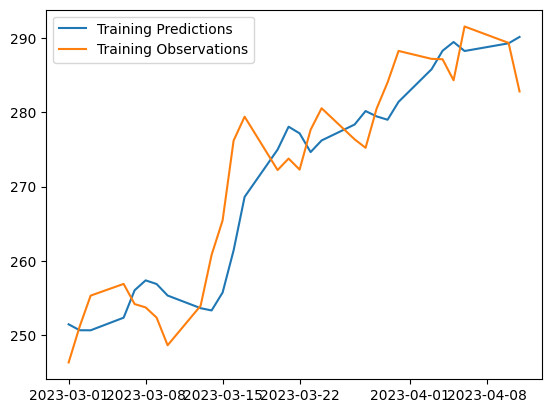

In [43]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 24ms/step


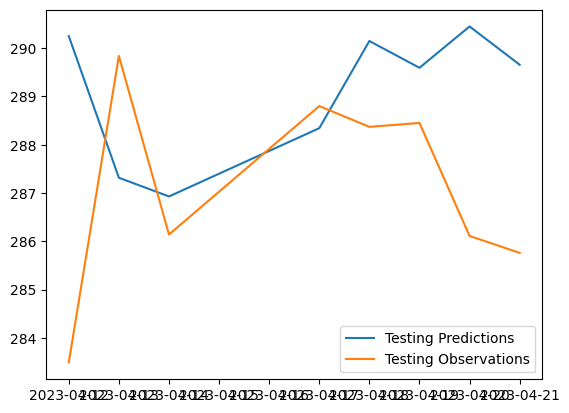

In [44]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

## Observations:

our model did really well on train data, but did poorly on test data, as the RNN tend to be more sensitive to overfitting than ANNs, we may need to use optimzers and other means to penalize overfitting and improve the performance